# 3-Body Problem Visualization

## [Original idea reference](https://towardsdatascience.com/modelling-the-three-body-problem-in-classical-mechanics-using-python-9dc270ad7767)
- solve diff-eq (scipy)
- non-dimensionalizing (harmonizing?) equation
- 3D-plot (matplotlib)

## [Animation reference](https://jckantor.github.io/CBE30338/A.03-Animation-in-Jupyter-Notebooks.html)


In [64]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [73]:
# Setup constants & reference-quantities to harmonize values
# universal gravitation constant
G=6.67408e-11 # m3/kgs2

# reference quantities
m_nd=1.989e+30 # kg: mass of the Sun
r_nd=5.326e+12 # m: distance between stars in Alpha Centauri
v_nd=3e4 # m/s: relative velocity of earth around the sun
t_nd=79.91*365*24*3600*0.51 #s #orbital period of Alpha Centauri

# harmonizing constants
Kv = G*t_nd*m_nd/(r_nd**2*v_nd) # on velocity
Kr = v_nd*t_nd/r_nd # on displacement

In [74]:
# Harmonized parameter
# masses rel our Sun
m1=1.1 #Alpha Centauri A
m2=0.907 #Alpha Centauri B
# init position-vector as (x,y,z)-array; arbitrary
r1=np.array([-0.5,0,0],dtype="float64") # m
r2=np.array([ 0.5,0,0],dtype="float64") # m
# init velocity-vector arrays
v1=np.array([ 0.01, 0.01, 0],dtype="float64") #m/s
v2=np.array([-0.05, 0,   -0.1],dtype="float64") #m/s

# calc Center-of-Mass (COM): m
def com(*list_mass_pos): # Tuple[(kg,m)] -> m
  masses, positions = zip(*list_mass_pos)
  return sum(mass*pos for mass,pos in list_mass_pos)/sum(masses)

# COM position: (-0.048,0,0) - nearer massier AC-A
print('p_com: %s'%com((m1,r1),(m2,r2)))

# COM velocity
print('v_com: %s'%com((m1,v1),(m2,v2)))

p_com: [-0.04808171  0.          0.        ]
v_com: [-0.0171151   0.00548082 -0.04519183]


In [87]:
# 2-body ODE
def ode2(w,t,G,m1,m2): # -> r1, r2, v1, v2
  r1, r2, v1, v2 = np.split(w, 4)
  r=sci.linalg.norm(r2-r1) # dist as vector-norm
  dv1_dt=Kv*m2*(r2-r1)/r**3
  dv2_dt=Kv*m1*(r1-r2)/r**3
  dr1_dt=Kr*v1
  dr2_dt=Kr*v2
  return np.concatenate((dr1_dt,dr2_dt,dv1_dt,dv2_dt))

# solve ODE
import scipy.integrate
sol2 = sci.integrate.odeint( # (500,12)
  func=ode2,
  y0=np.array([r1,r2,v1,v2]).flatten(), # 1D-array
  t=np.linspace(0,8,500), #8 orbital periods and 500 points
  args=(G,m1,m2))

r1_sol2, r2_sol2, v1_sol2, v2_sol2 = np.split(sol2, 4, axis=1)

(500, 3)

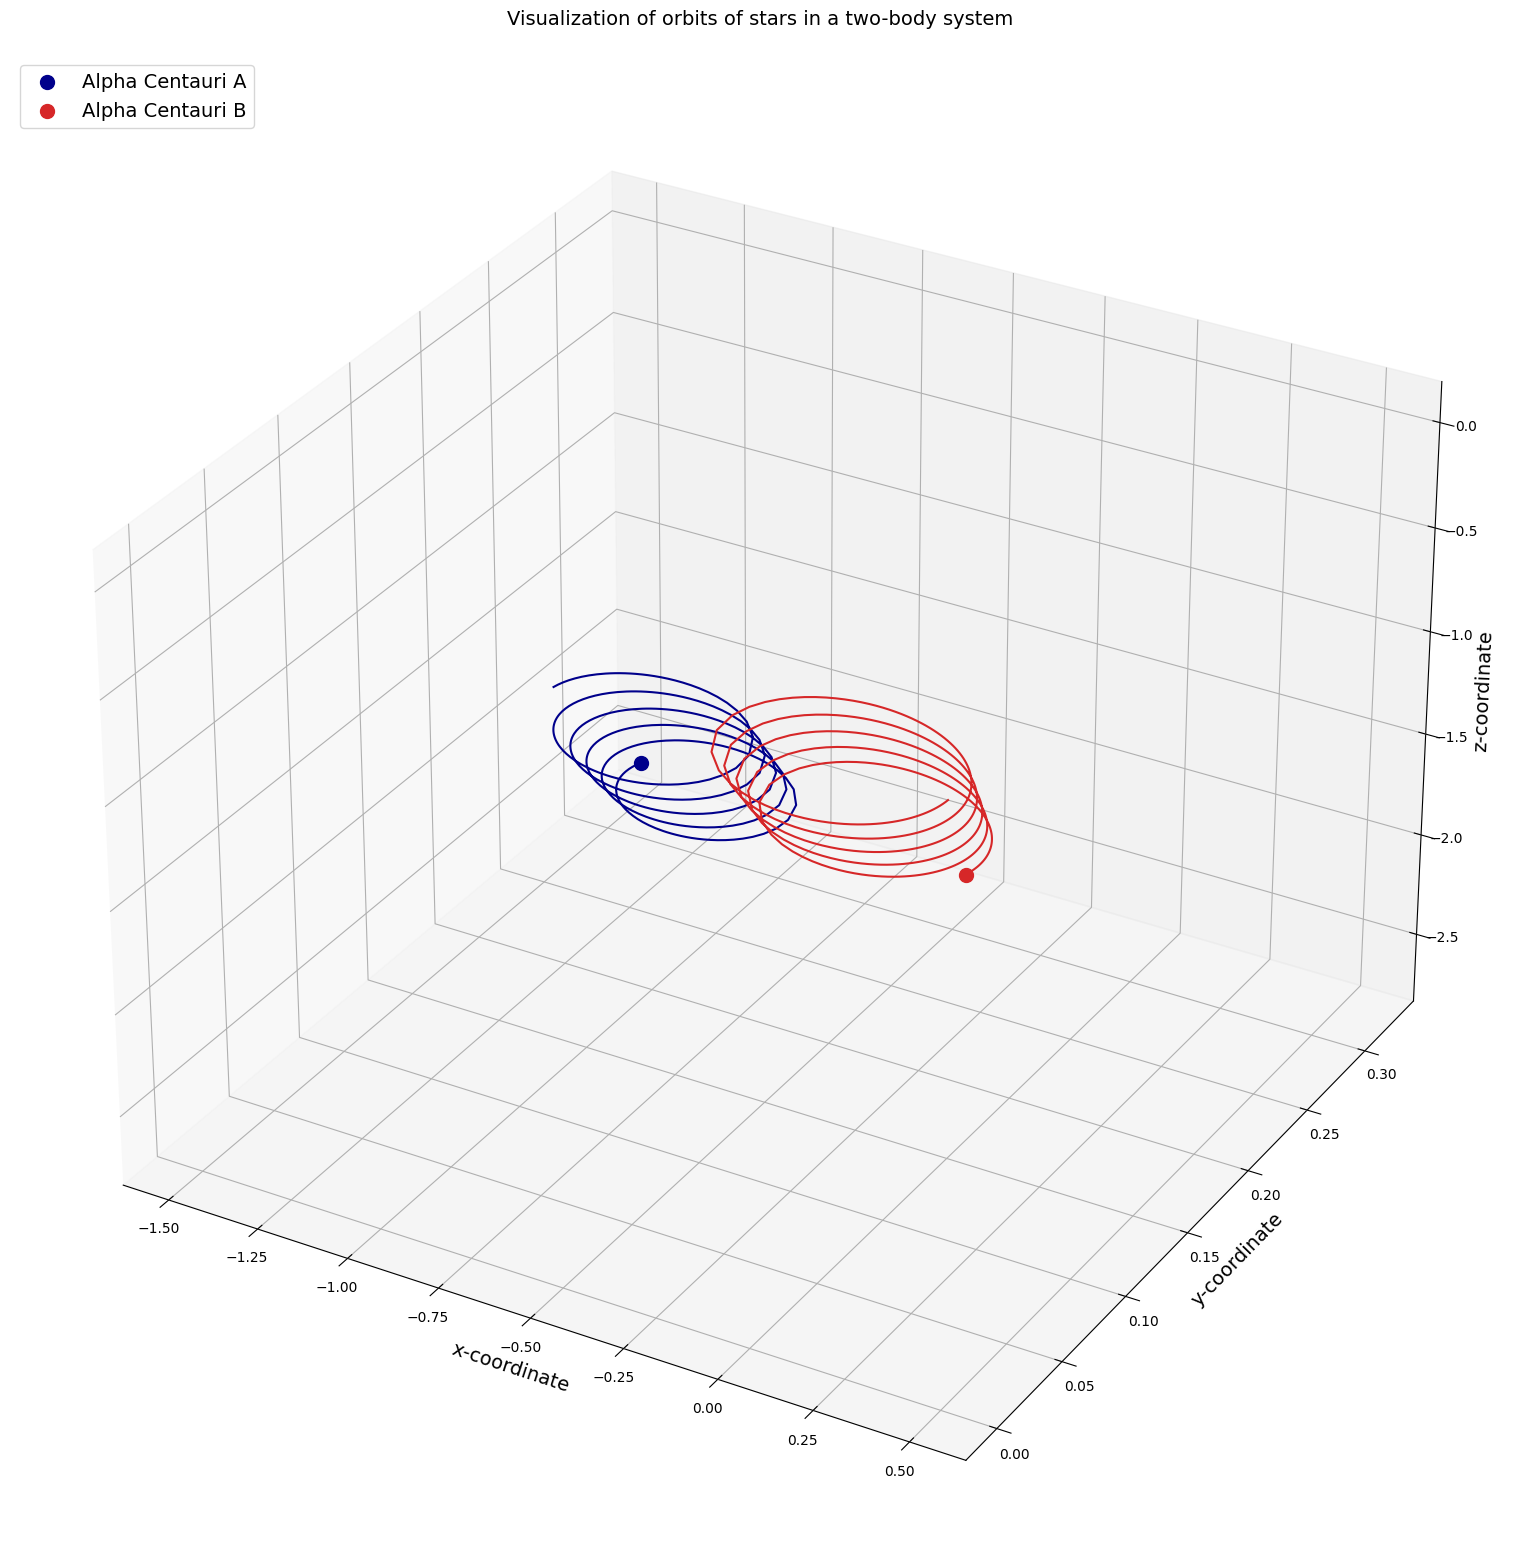

In [88]:
# Visualize trajectory & final-pos
def plot(*rs
  ,colors=['darkblue','tab:red','green']
  ,labels=['Alpha Centauri A', 'Alpha Centauri B', 'Third Star']):
  fig = plt.figure(figsize=(15,15), dpi=100)
  ax = Axes3D(fig)

  # plot each
  for r, color, label in zip(rs, colors, labels):
    # orbits
    ax.plot(r[:,0], r[:,1], r[:,2], color=color)
    # final pos
    ax.scatter(r[-1,0],r[-1,1],r[-1,2],color=color,marker="o",s=100,label=label)

  # label
  ax.set_xlabel("x-coordinate",fontsize=14)
  ax.set_ylabel("y-coordinate",fontsize=14)
  ax.set_zlabel("z-coordinate",fontsize=14)
  ax.set_title("Visualization of orbits of stars in a two-body system\n",fontsize=14)
  ax.legend(loc="upper left",fontsize=14)

plot(r1_sol2, r2_sol2)

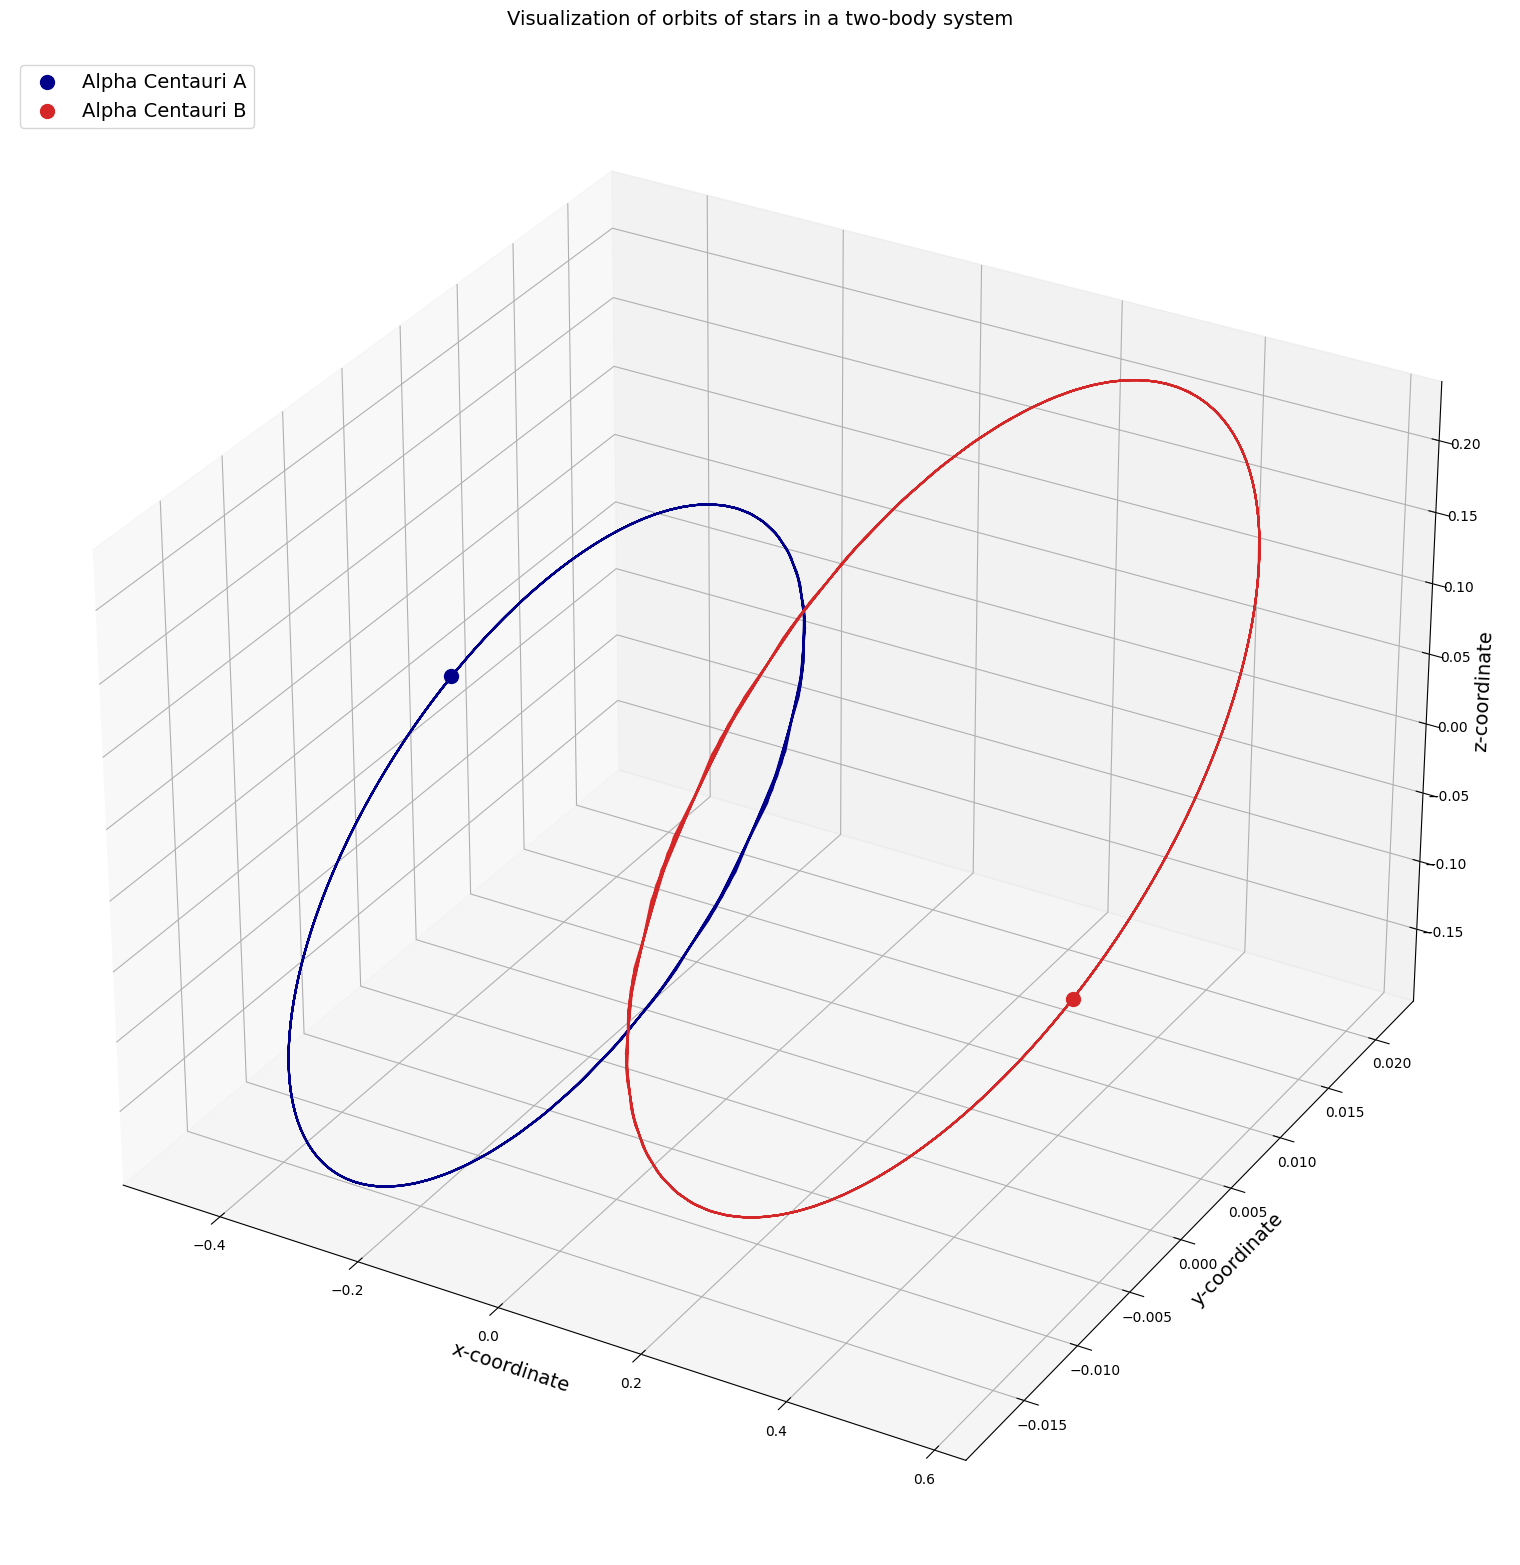

In [7]:
# Re-plot, centered on COM
# calc COM
r_com_2 = (m1*r1_sol2+m2*r2_sol2)/(m1+m2)
# locate Alpha Centauri A w.r.t COM
r1_sol2_com = r1_sol2 - r_com_2
# locate Alpha Centauri B w.r.t COM
r2_sol2_com = r2_sol2 - r_com_2

plot(r1_sol2_com, r2_sol2_com)

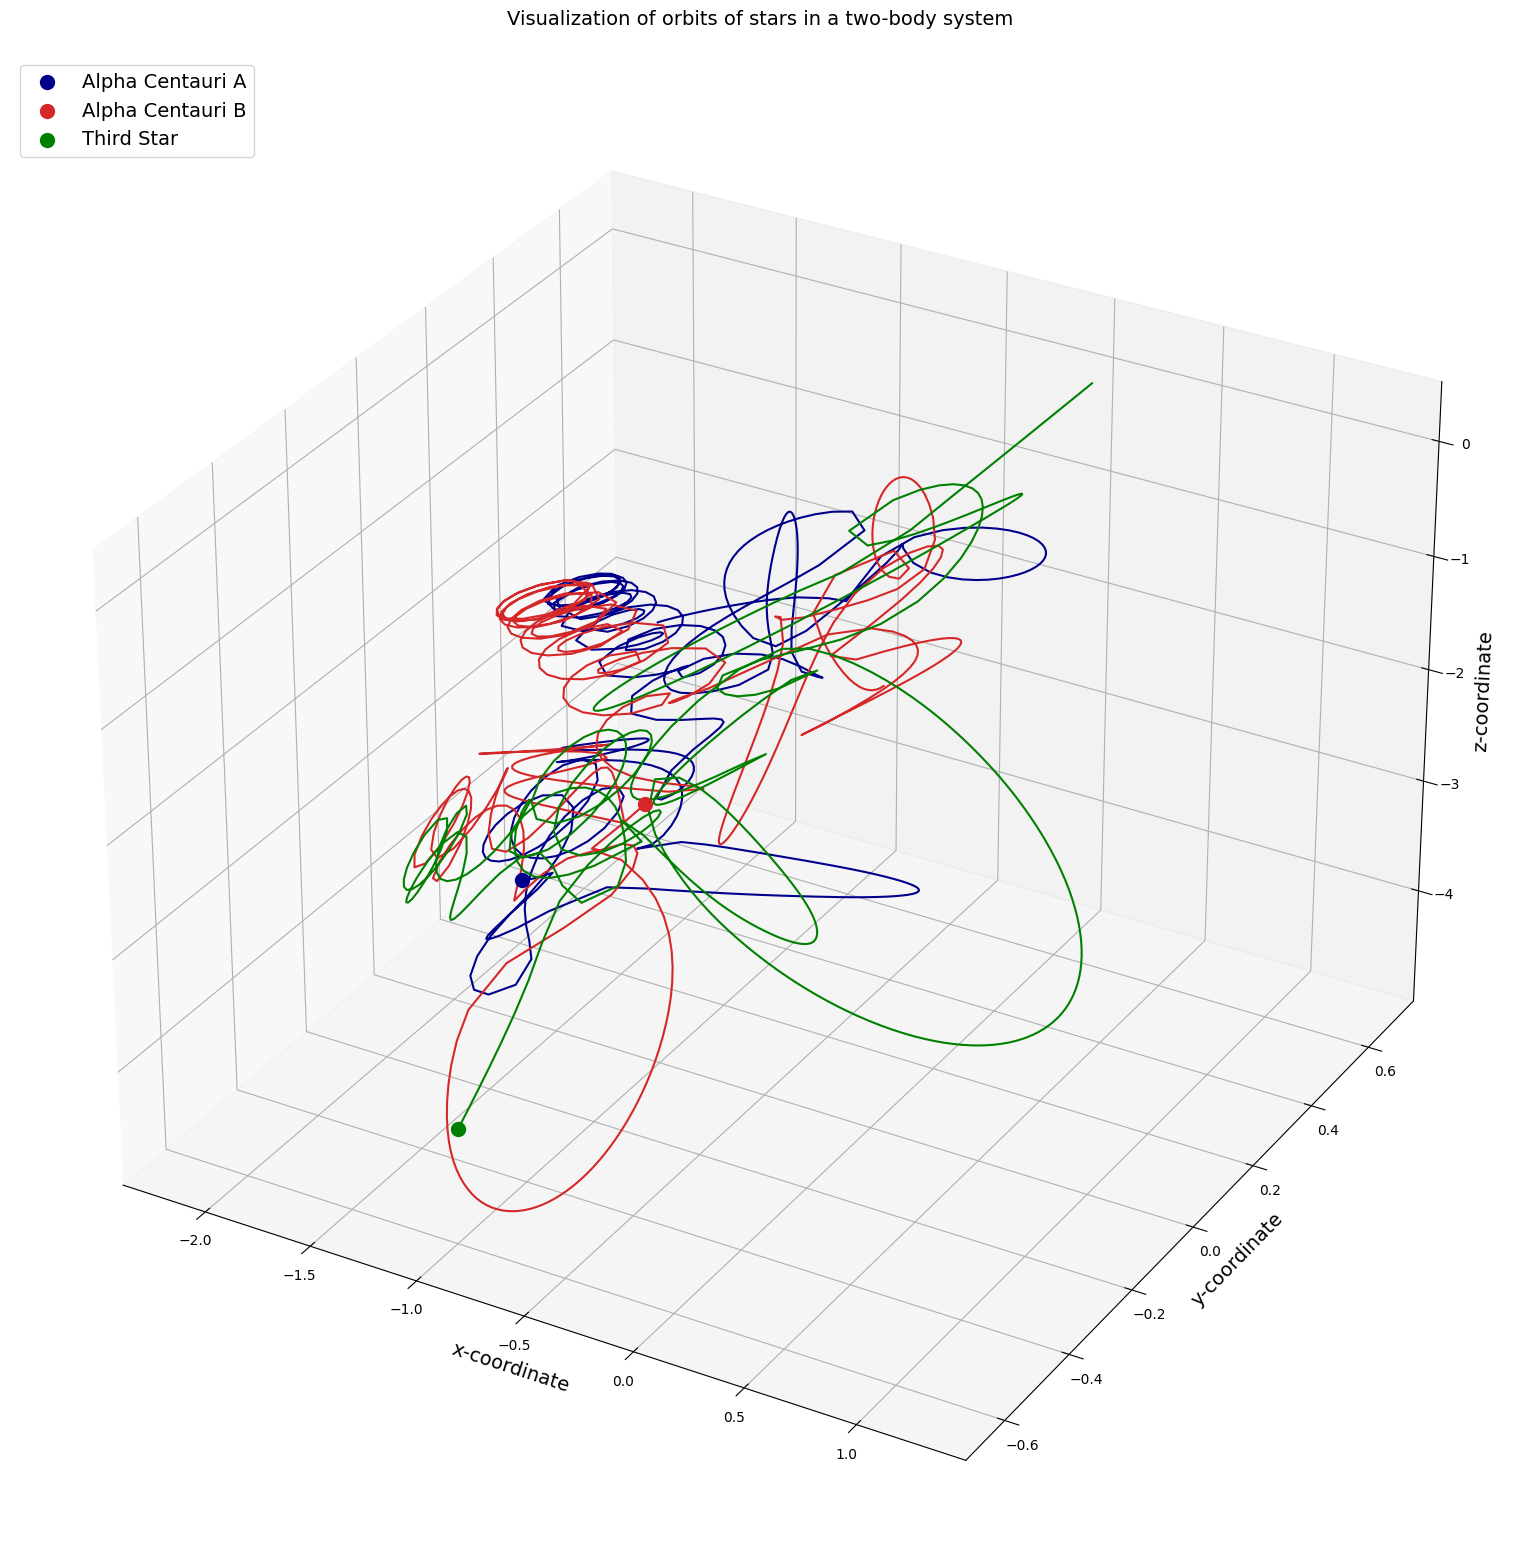

In [8]:
# Extend to 3rd body

# set mass, pos, velo
m3=1.0 #Third Star
r3=np.array([0,1,0],dtype="float64") # m
v3=np.array([0,-0.01,0],dtype="float64") # m/s

# re-calc COM pos, velo
r_com_3=(m1*r1+m2*r2+m3*r3)/(m1+m2+m3)
v_com_3=(m1*v1+m2*v2+m3*v3)/(m1+m2+m3)

def ThreeBodyEquations(w,t,G,m1,m2,m3):
  r1=w[:3]
  r2=w[3:6]
  r3=w[6:9]
  v1=w[9:12]
  v2=w[12:15]
  v3=w[15:18]
  r12=np.linalg.norm(r2-r1)
  r13=np.linalg.norm(r3-r1)
  r23=np.linalg.norm(r3-r2)

  dv1_dt=Kv*m2*(r2-r1)/r12**3+Kv*m3*(r3-r1)/r13**3
  dv2_dt=Kv*m1*(r1-r2)/r12**3+Kv*m3*(r3-r2)/r23**3
  dv3_dt=Kv*m1*(r1-r3)/r13**3+Kv*m2*(r2-r3)/r23**3
  dr1_dt=Kr*v1
  dr2_dt=Kr*v2
  dr3_dt=Kr*v3
  r12_derivs=np.concatenate((dr1_dt,dr2_dt))
  r_derivs=np.concatenate((r12_derivs,dr3_dt))
  v12_derivs=np.concatenate((dv1_dt,dv2_dt))
  v_derivs=np.concatenate((v12_derivs,dv3_dt))
  derivs=np.concatenate((r_derivs,v_derivs))
  return derivs

# init params
init_params=np.array([r1,r2,r3,v1,v2,v3]).flatten() # 1D-array
time_span=np.linspace(0,20,500) #20 orbital periods and 500 points

# solve ODE
import scipy.integrate
three_body_sol=sci.integrate.odeint(
  ThreeBodyEquations
  ,init_params
  ,time_span
  ,args=(G,m1,m2,m3))
r1_sol_3 = three_body_sol[:,:3] - r_com_3 # (500, 3)
r2_sol_3 = three_body_sol[:,3:6] - r_com_3
r3_sol_3 = three_body_sol[:,6:9] - r_com_3

plot(r1_sol_3, r2_sol_3, r3_sol_3)

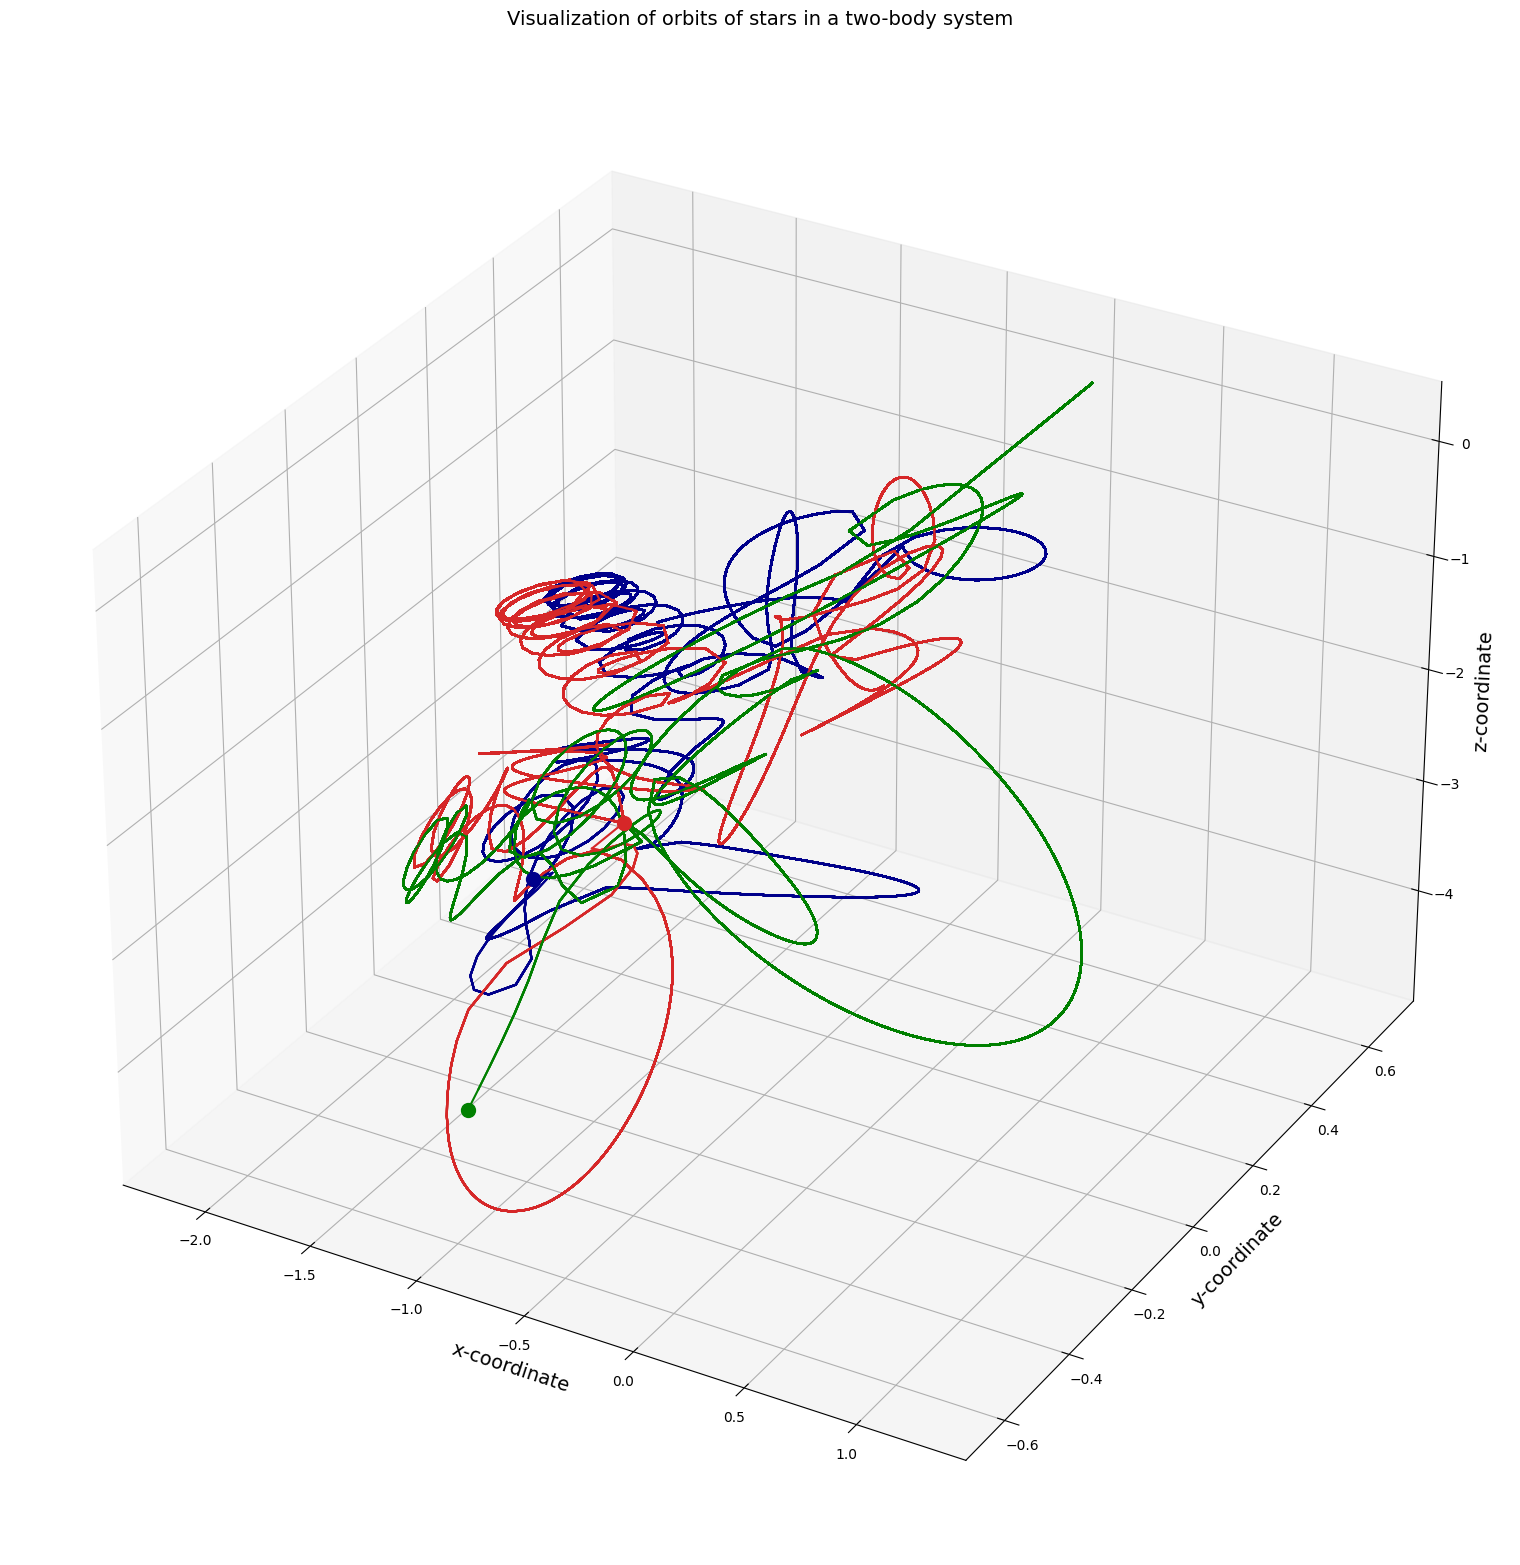

In [31]:
# Animate
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=20)

def animate(*data
  ,colors=['darkblue','tab:red','green']
  ,labels=['Alpha Centauri A', 'Alpha Centauri B', 'Third Star']):
  fig = plt.figure(figsize=(15,15), dpi=100)
  ax = Axes3D(fig)

  # label
  ax.set_xlabel("x-coordinate",fontsize=14)
  ax.set_ylabel("y-coordinate",fontsize=14)
  ax.set_zlabel("z-coordinate",fontsize=14)
  ax.set_title("Visualization of orbits of stars in a two-body system\n",fontsize=14)

  ## Two ways to animate
#   #1 init then update lines (blit=True: faster animation but doesn't auto-rescale)
#   lines = [ax.plot(d[0,0],d[0,1],d[0,2],color=color)[0]
#     for d,color in zip(data,colors)]
#   def update(i):
#     # update lines
#     for line, d in zip(lines, data):
#       line.set_data_3d(d[:i,:].T) # !!! not obvious at all...
#     return lines

  #1 init then redraw lines & dots (blit=False)
  heads = [[ax.scatter(d[0,0],d[0,1],d[0,2],color=color,marker='o',s=100)]
    for d,color in zip(data,colors)]
qdjfs  def redraw(i):
    # redraw lines
    lines = [ax.plot(d[:i,0],d[:i,1],d[:i,2],color=color)
      for d,color in zip(data,colors)]
    # redraw dots
    for d,head,color in zip(data,heads,colors):
      head[0].remove()
      head[0] = ax.scatter(d[i-1,0],d[i-1,1],d[i-1,2],color=color,marker='o',s=100)
    return *lines, *heads

  return animation.FuncAnimation(fig
#     ,func=update, blit=True
    ,func=redraw, blit=False
#     ,frames=10
    ,frames=len(time_span)
    ,interval=20, repeat=False)

animated = animate(r1_sol_3, r2_sol_3, r3_sol_3)
# HTML(animated.to_jshtml()) # interactive but HUGE
HTML(animated.to_html5_video())